<a href="https://colab.research.google.com/github/ran-cao/Creditcard-Fraud-Anomaly-Detection/blob/master/Pyod%20Knn%2C%20PCA%2C%20IForest%2C%20AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount= True)

Mounted at /content/gdrive


In [3]:
ccard = pd.read_csv('/content/gdrive/My Drive/anomaly detection/purchase_credit_card.csv')

In [ ]:
ccard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442458 entries, 0 to 442457
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Year-Month                    442458 non-null  int64  
 1   Agency Number                 442458 non-null  int64  
 2   Agency Name                   442458 non-null  object 
 3   Cardholder Last Name          442458 non-null  object 
 4   Cardholder First Initial      442458 non-null  object 
 5   Description                   442458 non-null  object 
 6   Amount                        442458 non-null  float64
 7   Vendor                        442458 non-null  object 
 8   Transaction Date              442458 non-null  object 
 9   Posted Date                   442458 non-null  object 
 10  Merchant Category Code (MCC)  442458 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 37.1+ MB


In [ ]:
ccard.head()

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...
3,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"GROCERY STORES,AND SUPERMARKETS"
4,201307,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT..."


# EDA

In [ ]:
ccard['Amount'].describe()

count    4.424580e+05
mean     4.249912e+02
std      5.266509e+03
min     -4.286304e+04
25%      3.091000e+01
50%      1.048900e+02
75%      3.450000e+02
max      1.903858e+06
Name: Amount, dtype: float64

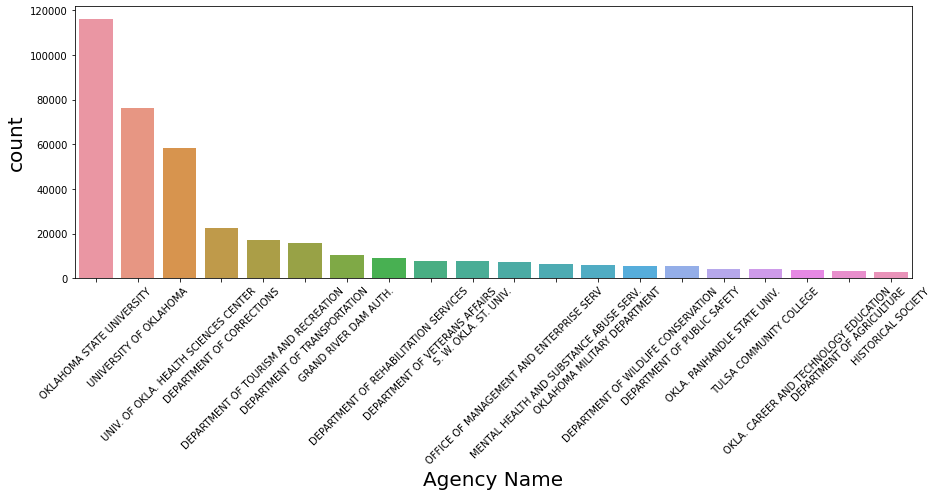

In [ ]:
plt.figure(figsize=(15,5))
txt = ccard['Agency Name'].value_counts()[:20].index

chart = sns.countplot(
    x='Agency Name' ,data=ccard , order=txt
)

_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.rcParams["axes.labelsize"] = 10

# **Feature Engineering**

8 new feartues are created, in each transactional level

4 ratios are detailed:


*   each agency average spending on each **merchant** category
*   each agency monthly spending on each **merchant** category
*   each agent's max spending over each month under each **vendor**
*   track the individual **cardholer** average spending

4 ratios are global/ general agency level: 
*   track the seasonal (3 months) maximum spending of each agency and create ratios
*  each agency average spending
*  each agency historical maximum spending
*  each agency historical minimum spending (since here we are not considering the effect of negative amount of the creditcard transactions, we want to find the minimum non-negative, non-zero spending of each cardholder). Track how much did the transaction amount exceed the minimum spending

Note: only study the positive transaction amount


## first feature: each agency average spending on each merchant category

In [4]:
# create a copy of previous dataframe that only containing the positive amount
ccard2 = ccard[ccard['Amount'] > 0]

In [5]:
ccard2.columns = ['Year-Month',	'Agency_Number',	'Agency_Name',	'Cardholder_LastName', 'Cardholder_FirstInitial',	'Description',	'Amount',	'Vendor',	'Transaction_Date',	'Posted_Date',	'Merchant_Category']

In [6]:
avg_agency = ccard2.groupby(['Agency_Name','Merchant_Category'])['Amount'].mean().reset_index()
avg_agency.columns = ['Agency_Name','Merchant_Category','Agency_Merchant_AvgSpending']
avg_agency.head()

,Agency_Name,Merchant_Category,Agency_Merchant_AvgSpending
0,ARDMORE HIGHER EDUCATION CENTER,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,115.120000
1,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,309.157500
2,ARDMORE HIGHER EDUCATION CENTER,COMPUTER NETWORK/INFORMATION SERVICES,18.340000
3,ARDMORE HIGHER EDUCATION CENTER,DRUG STORES AND PHARMACIES,153.450000
4,ARDMORE HIGHER EDUCATION CENTER,"GROCERY STORES,AND SUPERMARKETS",74.525455


In [7]:
# Join back to original table
ccard2 = ccard2.merge(avg_agency,on=['Agency_Name','Merchant_Category'],how='left')
ccard2['Agency_Merchant_AvgSpending_Ratio'] = ccard2['Amount']/ccard2['Agency_Merchant_AvgSpending']
ccard2.head(3)

,Year-Month,Agency_Number,Agency_Name,Cardholder_LastName,Cardholder_FirstInitial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Agency_Merchant_AvgSpending,Agency_Merchant_AvgSpending_Ratio
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,449.628734,1.979411
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON,470.991494,0.783369
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,415.132419,0.399439


## Feature 2: each agency monthly spending on each merchant category

In [8]:
per_agency_category = ccard2.groupby(['Agency_Name','Merchant_Category','Year-Month'])['Amount'].mean().reset_index()
per_agency_category.columns = ['Agency_Name','Merchant_Category','Year-Month','Agency_Merchant_Monthly_AvgSpending']
per_agency_category.head()

,Agency_Name,Merchant_Category,Year-Month,Agency_Merchant_Monthly_AvgSpending
0,ARDMORE HIGHER EDUCATION CENTER,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,201311,115.120
1,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201308,669.080
2,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201310,334.540
3,ARDMORE HIGHER EDUCATION CENTER,CATALOG MERCHANTS,201311,116.505
4,ARDMORE HIGHER EDUCATION CENTER,COMPUTER NETWORK/INFORMATION SERVICES,201310,18.340


In [9]:
# Join back to original table
ccard2 = ccard2.merge(per_agency_category,on=['Agency_Name','Merchant_Category','Year-Month'],how='left')
ccard2['Agency_Merchant_Monthly_AvgSpending_Ratio'] = ccard2['Amount']/ccard2['Agency_Merchant_Monthly_AvgSpending']
ccard2.head(3)

,Year-Month,Agency_Number,Agency_Name,Cardholder_LastName,Cardholder_FirstInitial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Agency_Merchant_AvgSpending,Agency_Merchant_AvgSpending_Ratio,Agency_Merchant_Monthly_AvgSpending,Agency_Merchant_Monthly_AvgSpending_Ratio
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,449.628734,1.979411,509.665227,1.746244
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON,470.991494,0.783369,491.115238,0.751270
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,415.132419,0.399439,403.522222,0.410932


## Third feature: each agent's max spending over each month under each vendor  

In [10]:
max_monthly_vendor = ccard2.groupby(['Agency_Name','Vendor','Year-Month'])['Amount'].max().reset_index()
max_monthly_vendor.columns = ['Agency_Name','Vendor','Year-Month','Monthly_Max_VendorSpending']
max_monthly_vendor.head()

,Agency_Name,Vendor,Year-Month,Monthly_Max_VendorSpending
0,ARDMORE HIGHER EDUCATION CENTER,AGRI PRODUCTS,201312,92.50
1,ARDMORE HIGHER EDUCATION CENTER,CDW GOVERNMENT,201308,669.08
2,ARDMORE HIGHER EDUCATION CENTER,CDW GOVERNMENT,201310,334.54
3,ARDMORE HIGHER EDUCATION CENTER,CDW GOVERNMENT,201311,194.85
4,ARDMORE HIGHER EDUCATION CENTER,COUNTY BUILDING CE,201307,58.44


In [11]:
#Join back to original table & create ratio 
ccard2 = ccard2.merge(max_monthly_vendor,on=['Agency_Name','Vendor','Year-Month'],how='left')
ccard2['Monthly_Max_VendorSpending_Ratio'] = ccard2['Amount']/ccard2['Monthly_Max_VendorSpending']
ccard2.head(3)

,Year-Month,Agency_Number,Agency_Name,Cardholder_LastName,Cardholder_FirstInitial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Agency_Merchant_AvgSpending,Agency_Merchant_AvgSpending_Ratio,Agency_Merchant_Monthly_AvgSpending,Agency_Merchant_Monthly_AvgSpending_Ratio,Monthly_Max_VendorSpending,Monthly_Max_VendorSpending_Ratio
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,449.628734,1.979411,509.665227,1.746244,970.00,0.917526
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON,470.991494,0.783369,491.115238,0.751270,368.96,1.000000
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,415.132419,0.399439,403.522222,0.410932,165.82,1.000000


## Fourth feature: track the individual cardholer average spending 



In [12]:
individual = ccard2.groupby(['Agency_Name','Cardholder_LastName','Cardholder_FirstInitial'])['Amount'].mean().reset_index()
individual.columns = ['Agency_Name','Cardholder_LastName','Cardholder_FirstInitial','cardholer_AvgSpending']
individual.head()

,Agency_Name,Cardholder_LastName,Cardholder_FirstInitial,cardholer_AvgSpending
0,ARDMORE HIGHER EDUCATION CENTER,Pollard,C,124.993333
1,ARDMORE HIGHER EDUCATION CENTER,Ray,M,160.757407
2,ARDMORE HIGHER EDUCATION CENTER,Stoker,C,136.262500
3,ATTORNEY GENERAL,Baustert,J,1367.959500
4,ATTORNEY GENERAL,Brown,A,179.335405


In [13]:
# Join back to original table and create feature
ccard2 = ccard2.merge(individual,on=['Agency_Name','Cardholder_LastName','Cardholder_FirstInitial'],how='left')
ccard2['cardholer_AvgSpending_Ratio'] = ccard2['Amount']/ccard2['cardholer_AvgSpending']
ccard2.head(3)

,Year-Month,Agency_Number,Agency_Name,Cardholder_LastName,Cardholder_FirstInitial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Agency_Merchant_AvgSpending,Agency_Merchant_AvgSpending_Ratio,Agency_Merchant_Monthly_AvgSpending,Agency_Merchant_Monthly_AvgSpending_Ratio,Monthly_Max_VendorSpending,Monthly_Max_VendorSpending_Ratio,cardholer_AvgSpending,cardholer_AvgSpending_Ratio
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,449.628734,1.979411,509.665227,1.746244,970.00,0.917526,359.168832,2.477943
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON,470.991494,0.783369,491.115238,0.751270,368.96,1.000000,359.168832,1.027261
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,415.132419,0.399439,403.522222,0.410932,165.82,1.000000,430.372455,0.385294


Create four global (general) features to track the agency performance in terms of the agency level

## Fifth Feature: each agency average spending

In [14]:
Agency_Avgspending = ccard2.groupby(['Agency_Name'])['Amount'].mean().reset_index()
Agency_Avgspending.columns = ['Agency_Name','Agency_AvgSpending']
Agency_Avgspending.head(3)

,Agency_Name,Agency_AvgSpending
0,ARDMORE HIGHER EDUCATION CENTER,147.883889
1,ATTORNEY GENERAL,467.489798
2,BD. OF CHEM. TEST ALCOHOL/DRUG,389.371358


In [15]:
# Join back to original table & create ratio
ccard2 = ccard2.merge(Agency_Avgspending,on=['Agency_Name'],how='left')
ccard2['Agency_AvgSpending_Ratio'] = ccard2['Amount']/ccard2['Agency_AvgSpending']
ccard2.head(3)

,Year-Month,Agency_Number,Agency_Name,Cardholder_LastName,Cardholder_FirstInitial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Agency_Merchant_AvgSpending,Agency_Merchant_AvgSpending_Ratio,Agency_Merchant_Monthly_AvgSpending,Agency_Merchant_Monthly_AvgSpending_Ratio,Monthly_Max_VendorSpending,Monthly_Max_VendorSpending_Ratio,cardholer_AvgSpending,cardholer_AvgSpending_Ratio,Agency_AvgSpending,Agency_AvgSpending_Ratio
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,449.628734,1.979411,509.665227,1.746244,970.00,0.917526,359.168832,2.477943,306.916878,2.899808
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON,470.991494,0.783369,491.115238,0.751270,368.96,1.000000,359.168832,1.027261,306.916878,1.202150
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,415.132419,0.399439,403.522222,0.410932,165.82,1.000000,430.372455,0.385294,306.916878,0.540277


## Sixth Feature: each agency maximum spending

In [16]:
Agency_Maxspending = ccard2.groupby(['Agency_Name'])['Amount'].max().reset_index()
Agency_Maxspending.columns = ['Agency_Name','Agency_MaxSpending']
Agency_Maxspending.head(3)

,Agency_Name,Agency_MaxSpending
0,ARDMORE HIGHER EDUCATION CENTER,750.17
1,ATTORNEY GENERAL,15223.30
2,BD. OF CHEM. TEST ALCOHOL/DRUG,1580.00


In [17]:
# Join back to original table & create ratio
ccard2 = ccard2.merge(Agency_Maxspending,on=['Agency_Name'],how='left')
ccard2['Agency_MaxSpending_Ratio'] = ccard2['Amount']/ccard2['Agency_MaxSpending']
ccard2.head(3)

,Year-Month,Agency_Number,Agency_Name,Cardholder_LastName,Cardholder_FirstInitial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Agency_Merchant_AvgSpending,Agency_Merchant_AvgSpending_Ratio,Agency_Merchant_Monthly_AvgSpending,Agency_Merchant_Monthly_AvgSpending_Ratio,Monthly_Max_VendorSpending,Monthly_Max_VendorSpending_Ratio,cardholer_AvgSpending,cardholer_AvgSpending_Ratio,Agency_AvgSpending,Agency_AvgSpending_Ratio,Agency_MaxSpending,Agency_MaxSpending_Ratio
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,449.628734,1.979411,509.665227,1.746244,970.00,0.917526,359.168832,2.477943,306.916878,2.899808,27967.38,0.031823
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON,470.991494,0.783369,491.115238,0.751270,368.96,1.000000,359.168832,1.027261,306.916878,1.202150,27967.38,0.013193
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,415.132419,0.399439,403.522222,0.410932,165.82,1.000000,430.372455,0.385294,306.916878,0.540277,27967.38,0.005929


## Seventh Feature: each agency historical minimum "effective" "spending" that is non-negative or non-zero (bigger than 0). Track how much did the transaction amount exceed the minimum spending




In [18]:
Agency_Minspending = ccard2.groupby(['Agency_Name'])['Amount'].min().reset_index()
Agency_Minspending.columns = ['Agency_Name','Agency_MinSpending']
Agency_Minspending.head(3)

,Agency_Name,Agency_MinSpending
0,ARDMORE HIGHER EDUCATION CENTER,1.00
1,ATTORNEY GENERAL,0.62
2,BD. OF CHEM. TEST ALCOHOL/DRUG,9.20


In [19]:
ccard2 = ccard2.merge(Agency_Minspending,on=['Agency_Name'],how='left')
ccard2['Agency_Exceed_MinSpending_Percentage'] = (ccard2['Amount']-ccard2['Agency_MinSpending'])/ccard2['Agency_MinSpending']
ccard2.head(3)

,Year-Month,Agency_Number,Agency_Name,Cardholder_LastName,Cardholder_FirstInitial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Agency_Merchant_AvgSpending,Agency_Merchant_AvgSpending_Ratio,Agency_Merchant_Monthly_AvgSpending,Agency_Merchant_Monthly_AvgSpending_Ratio,Monthly_Max_VendorSpending,Monthly_Max_VendorSpending_Ratio,cardholer_AvgSpending,cardholer_AvgSpending_Ratio,Agency_AvgSpending,Agency_AvgSpending_Ratio,Agency_MaxSpending,Agency_MaxSpending_Ratio,Agency_MinSpending,Agency_Exceed_MinSpending_Percentage
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,449.628734,1.979411,509.665227,1.746244,970.00,0.917526,359.168832,2.477943,306.916878,2.899808,27967.38,0.031823,0.01,88999.0
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON,470.991494,0.783369,491.115238,0.751270,368.96,1.000000,359.168832,1.027261,306.916878,1.202150,27967.38,0.013193,0.01,36895.0
2,201307,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,07/29/2013 12:00:00 AM,07/31/2013 12:00:00 AM,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,415.132419,0.399439,403.522222,0.410932,165.82,1.000000,430.372455,0.385294,306.916878,0.540277,27967.38,0.005929,0.01,16581.0


## Take a look at the maximum & minimum of these ratios

In [ ]:
max(ccard2.Agency_Merchant_AvgSpending_Ratio)

202.2126389528295

In [ ]:
min(ccard2.Agency_Merchant_AvgSpending_Ratio)

4.179975212145165e-06

In [ ]:
max(ccard2.Agency_Merchant_Monthly_AvgSpending_Ratio)

111.97828170019157

In [ ]:
min(ccard2.Agency_Merchant_Monthly_AvgSpending_Ratio)

3.656007008885337e-06

In [ ]:
max(ccard2.Monthly_Max_VendorSpending_Ratio)

1.0

In [ ]:
min(ccard2.Monthly_Max_VendorSpending_Ratio)

2.2160566601366863e-06

In [ ]:
max(ccard2.cardholer_AvgSpending_Ratio)

106.72871347890951

In [ ]:
min(ccard2.cardholer_AvgSpending_Ratio)

8.756954400330042e-08

In [ ]:
max(ccard2.Agency_AvgSpending_Ratio)

4303.243008834281

In [ ]:
min(ccard2.Agency_AvgSpending_Ratio)

1.4560487827221946e-05

In [ ]:
max(ccard2.Agency_MaxSpending_Ratio)

1.0

In [ ]:
min(ccard2.Agency_MaxSpending_Ratio)

5.252491549568364e-09

In [ ]:
max(ccard2.Agency_Exceed_MinSpending_Percentage)

190385836.0

In [ ]:
min(ccard2.Agency_Exceed_MinSpending_Percentage)

0.0

The Eighth feature to be used in modeling is the orginal "Amount" variable

In [ ]:
max(ccard2.Amount)

1903858.37

In [ ]:
min(ccard2.Amount)

0.01

## Get the data ready for modeling
Got rid of the variables that is not at the "transaction" level, and the character variables

In [ ]:
ccard2.columns

Index(['Year-Month', 'Agency_Number', 'Agency_Name', 'Cardholder_LastName',
       'Cardholder_FirstInitial', 'Description', 'Amount', 'Vendor',
       'Transaction_Date', 'Posted_Date', 'Merchant_Category',
       'Agency_Merchant_AvgSpending', 'Agency_Merchant_AvgSpending_Ratio',
       'Agency_Merchant_Monthly_AvgSpending',
       'Agency_Merchant_Monthly_AvgSpending_Ratio',
       'Monthly_Max_VendorSpending', 'Monthly_Max_VendorSpending_Ratio',
       'cardholer_AvgSpending', 'cardholer_AvgSpending_Ratio',
       'Agency_AvgSpending', 'Agency_AvgSpending_Ratio', 'Agency_MaxSpending',
       'Agency_MaxSpending_Ratio', 'Agency_MinSpending',
       'Agency_Exceed_MinSpending_Percentage'],
      dtype='object')

In [23]:
ccard3 = ccard2.drop(columns=['Year-Month', 'Agency_Number', 'Agency_Name', 'Cardholder_LastName',
       'Cardholder_FirstInitial', 'Description', 'Vendor',
       'Transaction_Date', 'Posted_Date', 'Merchant_Category',
       'Agency_Merchant_AvgSpending','Agency_Merchant_Monthly_AvgSpending',
       'Monthly_Max_VendorSpending', 'Agency_AvgSpending', 'Agency_MaxSpending', 'Agency_MinSpending', 'cardholer_AvgSpending'])

In [24]:
ccard3.head(3)

,Amount,Agency_Merchant_AvgSpending_Ratio,Agency_Merchant_Monthly_AvgSpending_Ratio,Monthly_Max_VendorSpending_Ratio,cardholer_AvgSpending_Ratio,Agency_AvgSpending_Ratio,Agency_MaxSpending_Ratio,Agency_Exceed_MinSpending_Percentage
0,890.00,1.979411,1.746244,0.917526,2.477943,2.899808,0.031823,88999.0
1,368.96,0.783369,0.751270,1.000000,1.027261,1.202150,0.013193,36895.0
2,165.82,0.399439,0.410932,1.000000,0.385294,0.540277,0.005929,16581.0


# **Modeling**

In [27]:
from pyod.models.knn import KNN
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.model_selection import train_test_split

In [25]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(ccard3)
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7
0,0.082654,0.442961,0.421547,0.771961,0.812971,0.198875,0.388171,0.154940
1,-0.014725,-0.097976,-0.140506,0.964083,0.014995,0.021161,-0.007153,0.027913
2,-0.052690,-0.271618,-0.332760,0.964083,-0.338131,-0.048125,-0.161279,-0.021611
3,-0.065666,0.239570,0.401657,-0.979991,-0.410595,-0.071805,-0.213957,-0.038537
4,-0.060140,-0.254685,-0.307307,-0.950844,0.164436,-0.061720,-0.191522,-0.031328


In [28]:
X_train, X_test= train_test_split(X, test_size=0.33, random_state=42)

In [29]:
X_train.head()

,0,1,2,3,4,5,6,7
186422,0.045948,0.117947,0.145817,0.964083,0.484865,0.103909,-0.158216,0.107059
407795,0.005654,-0.059302,-0.149380,0.964083,0.442514,0.039070,-0.198276,0.054497
370282,0.269318,1.494071,1.520460,0.964083,3.981806,0.539534,1.145966,0.398436
11084,-0.058564,-0.302891,-0.322499,-1.175433,-0.305470,-0.058845,-0.185126,-0.029273
12798,0.381569,3.055217,0.438762,0.964083,3.697464,0.744391,1.601668,0.544863


In [30]:
X_test.head()

,0,1,2,3,4,5,6,7
4161,0.027761,-0.204454,-0.293018,-0.524047,0.405679,0.098698,0.165327,0.083335
209653,-0.069430,-0.305190,-0.345507,-0.791959,-0.467267,-0.086640,-0.286240,-0.043447
401656,-0.076766,0.089608,0.277440,0.964083,-0.473237,-0.093554,-0.280215,-0.053016
130740,-0.076210,-0.309715,-0.213259,-0.546639,-0.512045,-0.093152,-0.273186,-0.052292
192415,0.012195,0.092886,0.356503,0.964083,4.376190,0.049596,-0.191773,0.063029


In [31]:
X_test1=X_test.reset_index()
X_test1=X_test1.drop(['index'], axis = 1) 

## IForest: 
**based on the idea that "an outlier should be the easiest to be isolated", to isolate anomalies instead of profiling normal data points. Anomalies are isolated closer to the root of the tree; whereas normal points are isolated at the deeper end of the tree.**

Create three models: clf1, clf2,and clf3
Model 1: max_samples = 100
Model 2: max_samples = 1000
Model 3: max_samples = 5000





### IForest Model 1

In [ ]:
clf1 = IForest(behaviour="new", max_samples=100) 
clf1.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=100, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

After modeling, there is an anomaly score for each observation in the training dataset X_Train.

In [ ]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores = clf1.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

0   -0.034358
1   -0.155301
2   -0.151810
3   -0.164190
4   -0.042421
dtype: float64

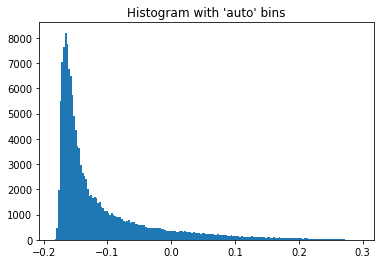

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

The graph is hard to tell the outliers as it's very smooth, and I believe the reason is that there're too many data points. From the graph above, the cutting point is set to be 0.2

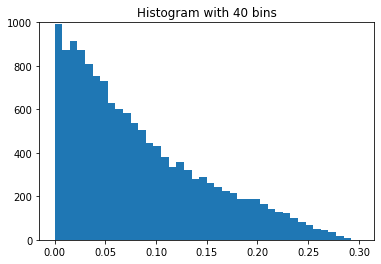

In [ ]:
#zoom in 
plt.hist(y_test_scores, bins=40, range=(0,0.3))  
plt.title("Histogram with 40 bins")
axes = plt.gca()
axes.set_ylim([0,1000])
plt.show()

In [ ]:
df_test_ifor1 = X_test1.copy()
df_test_ifor1['score'] = y_test_scores

In [ ]:
df_test_ifor1['cluster'] = np.where(df_test_ifor1['score']<0.2, 0, 1)
df_test_ifor1['cluster'].value_counts()

0    140201
1      1015
Name: cluster, dtype: int64

In [ ]:
df_test_ifor1.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,score
cluster,,,,,,,,,,
0,-0.020514,-0.024014,-0.042531,-0.040094,-0.008565,-0.019344,-0.033931,-0.012454,-0.036929,-0.114428
1,3.173201,3.234965,6.018497,5.428900,0.864070,2.859029,4.392904,1.894587,5.068856,0.230166


Out of 141216 rows creditcard transaction data in the test dataset, 1015 transactions are labeled to be outliers (0.72%). The summary statistics show that cluster 1 (outlier group) has all large positive values for these standardized values

### IForest Model2 

In [ ]:
clf2 = IForest(behaviour="new", max_samples=1000) 
clf2.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=1000, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [ ]:
y_test_scores2 = clf2.decision_function(X_test)  # outlier scores
y_test_scores2 = pd.Series(y_test_scores2)
y_test_scores2.head()

0    0.001073
1   -0.081870
2   -0.080005
3   -0.080695
4    0.018664
dtype: float64

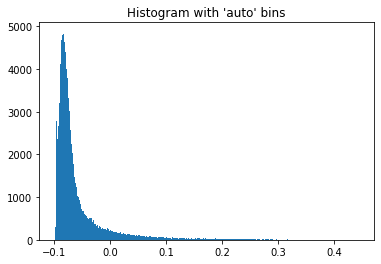

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores2, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

Similar to the last one, the graph is smooth.

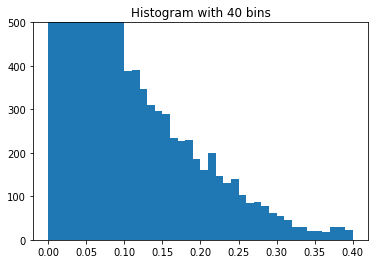

In [ ]:
# zoom in 
plt.hist(y_test_scores2, bins=40, range = (0,0.4))  # arguments are passed to np.histogram
plt.title("Histogram with 40 bins")
axes = plt.gca()
axes.set_ylim([0,500])
plt.show()

0.2 is set to be the cutting point

In [ ]:
df_test_ifor2 = X_test1.copy()
df_test_ifor2['score'] = y_test_scores2

In [ ]:
df_test_ifor2['cluster'] = np.where(df_test_ifor2['score']<0.2, 0, 1)
df_test_ifor2['cluster'].value_counts()

0    139695
1      1521
Name: cluster, dtype: int64

In [ ]:
df_test_ifor2.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,score
cluster,,,,,,,,,,
0,-0.023434,-0.035645,-0.054509,-0.051941,-0.010717,-0.022472,-0.049614,-0.014081,-0.046948,-0.059685
1,2.378916,3.218988,5.102272,4.697584,0.771413,2.188766,4.360574,1.409545,4.290399,0.264502


Out of 141216 rows creditcard transaction data in the test dataset, 1521 transactions are labeled to be outliers (1.08%). The summary statistics show that cluster 1 (outlier group) has all large positive values for these standardized values. Comparing to the model 1, as the cutting off line was pushed right further, the standardized values of outlier group got larger.

### IForest Model 3

In [ ]:
clf3 = IForest(behaviour="new", max_samples=10000) 
clf3.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=10000, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [ ]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores3 = clf3.decision_function(X_test)  # outlier scores
y_test_scores3 = pd.Series(y_test_scores3)
y_test_scores3.head()

0   -0.011554
1   -0.050470
2   -0.053795
3   -0.044519
4    0.018538
dtype: float64

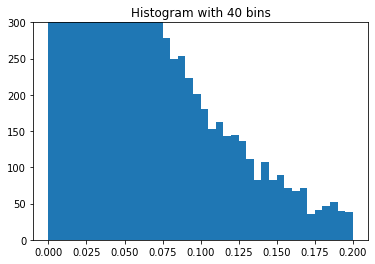

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores3, bins=40, range=(0,0.2))  # arguments are passed to np.histogram
plt.title("Histogram with 40 bins")
axes = plt.gca()
axes.set_ylim([0,300])
plt.show()

0.175 is set to be the cutting point

In [ ]:
df_test_ifor3 = X_test1.copy()
df_test_ifor3['score'] = y_test_scores3

In [ ]:
df_test_ifor3['cluster'] = np.where(df_test_ifor3['score']<0.175, 0, 1)
df_test_ifor3['cluster'].value_counts()

0    140325
1       891
Name: cluster, dtype: int64

In [ ]:
df_test_ifor3.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,score
cluster,,,,,,,,,,
0,-0.020051,-0.027389,-0.038653,-0.035284,-0.006454,-0.017519,-0.036371,-0.011151,-0.029057,-0.038472
1,3.544750,4.220099,6.251323,5.432524,0.653082,2.972224,5.393286,1.954719,4.539651,0.260102


Out of 141216 rows creditcard transaction data in the test dataset, 891 transactions are labeled to be outliers (0.63%). 

### IForest Model 4

In [ ]:
clf4 = IForest(behaviour="new", max_samples=100000) 
clf4.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=100000, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [ ]:
y_test_scores4 = clf4.decision_function(X_test)  # outlier scores
y_test_scores4 = pd.Series(y_test_scores4)
y_test_scores4.head()

0   -0.003349
1   -0.030307
2   -0.042196
3   -0.025527
4    0.001778
dtype: float64

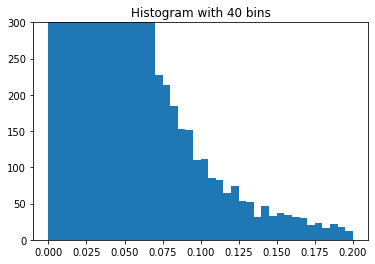

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores4, bins=40, range=(0,0.2))  # arguments are passed to np.histogram
plt.title("Histogram with 40 bins")
axes = plt.gca()
axes.set_ylim([0,300])
plt.show()

Set the cutting off point to be 0.1 as the data tend to be discontinous when data is greater than 0.1 

In [ ]:
df_test_ifor4 = X_test1.copy()
df_test_ifor4['score'] = y_test_scores4

In [ ]:
df_test_ifor4['cluster'] = np.where(df_test_ifor4['score']<0.1, 0, 1)
df_test_ifor4['cluster'].value_counts()

0    140052
1      1164
Name: cluster, dtype: int64

In [ ]:
df_test_ifor4.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,score
cluster,,,,,,,,,,
0,-0.020919,-0.030881,-0.043088,-0.039581,-0.006584,-0.018643,-0.042040,-0.011684,-0.035150,-0.026958
1,2.813165,3.644038,5.309720,4.667120,0.513992,2.406321,4.801895,1.557768,4.201203,0.169354


Out of 141216 rows creditcard transaction data in the test dataset, 1164 transactions are labeled to be outliers (0.82%). 

### Achieve Model Stability by Aggregating Multiple Models

Unsupervised techniques can detect many outliers. But due to its unspervised nature it is not stable, meaning overfitting to a specific dataset.
The solution is to train multiple models then aggregate the scores.
There are four methods to aggregate the outcome:

(1) Average: average scores of all detectors.

(2) Maximum of Maximum (MOM)

(3) Average of Maximum (AOM)

(4) Maximum of Average (MOA)

In [ ]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

In [ ]:
# The predictions of the training data can be obtained by clf.decision_scores_.
# It is already generated during the model building process.
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_,
                             'clf4': clf3.decision_scores_
                            })

# The predictions of the test data need to be predicted using clf.decision_function(X_test)
test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test),
                             'clf4': clf3.decision_function(X_test)
                            })

In [ ]:
train_scores.head()

,clf1,clf2,clf3,clf4
0,-0.077181,-0.059068,-0.045846,-0.045846
1,-0.105822,-0.072291,-0.052804,-0.052804
2,0.110744,0.081720,0.029147,0.029147
3,-0.140906,-0.078093,-0.050999,-0.050999
4,0.150849,0.132334,0.055131,0.055131


In [ ]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

Average

The "average" function in PyOD averages the outlier scores from multiple estimators

In [ ]:
# Combination by average
y_by_average = average(test_scores_norm)
y_by_average[1:10]

array([-0.42036042, -0.44187785, -0.37042011,  1.22483123, -0.59599304,
       -0.63886318,  0.39344822, -0.68339878, -0.39642173])

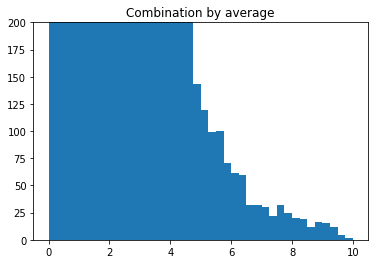

In [ ]:
# Combination by average
y_by_average = average(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins=40, range=(0,10))  # arguments are passed to np.histogram
plt.title("Combination by average")
axes = plt.gca()
axes.set_ylim([0,200])
plt.show()

set the cutting off point to be 7

In [ ]:
df_test_iforavg = X_test1.copy()
df_test_iforavg['score'] = y_by_average

In [ ]:
df_test_iforavg['cluster'] = np.where(df_test_iforavg['score']<7, 0, 1)
df_test_iforavg['cluster'].value_counts()

0    141005
1       211
Name: cluster, dtype: int64

In [ ]:
df_test_iforavg.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,score
cluster,,,,,,,,,,
0,-0.013639,-0.013115,-0.017868,-0.014654,-0.003547,-0.010890,-0.012989,-0.007644,-0.012531,-0.012152
1,10.748514,8.369446,12.632132,9.266991,0.836209,8.177459,7.265907,5.947146,8.219073,8.097733


Out of 141216 rows creditcard transaction data in the test dataset, 211 transactions are labeled to be outliers (0.15%).

Maximum of maximum

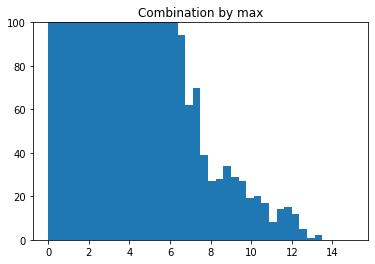

In [ ]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins=40, range=(0,15))  # arguments are passed to np.histogram
plt.title("Combination by max")
axes = plt.gca()
axes.set_ylim([0,100])
plt.show()

The cutting off point is >=6

In [ ]:
df_test_iformax = X_test1.copy()
df_test_iformax['score'] = y_by_maximization

In [ ]:
df_test_iformax['cluster'] = np.where(df_test_iformax['score']<=6, 0, 1)
df_test_iformax['cluster'].value_counts()

0    140587
1       629
Name: cluster, dtype: int64

In [ ]:
df_test_iformax.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,score
cluster,,,,,,,,,,
0,-0.018067,-0.023430,-0.032453,-0.029316,-0.005540,-0.015466,-0.028519,-0.010290,-0.023545,0.137081
1,4.586186,5.104517,7.485463,6.376127,0.723542,3.758770,5.899780,2.581305,5.210534,8.003431


Out of 141216 rows creditcard transaction data in the test dataset, 629 transactions are labeled to be outliers (0.45%).

### IForest Conclusion
The general statistis of the IForest result is:


*   Outlier group contains less than 1% of overall test transaction data 
*   For all these models, the summary statistics show that cluster 1 (outlier group) has all large positive values for these standardized values, except for column 4 (the ratio of each transaction comparing to the maximum monthly spending under different vendors for each agency). The columns with the highest values is column 3 (the ratio of each transaction comparing to the average monthly spending under different merchants for each agency).



## Autoencoder:  
the autoencoder techniques can perform non-linear transformations with their non-linear activation function and multiple layers. 

build three models: clf1, clf2, and clf3

*   auto1 has hidden_neurons = [9, 2, 2, 9]
*   auto2 has hidden_neurons = [9, 4, 2, 4, 9]
*   auto3 has hidden_neurons = [9, 6, 4, 2, 4, 6, 9]

The number of the hidden layers and the number of neutrons in a hidden layer: if there are too many hidden layers or too many neutrons, the model tends to overfit; otherwise the model tends to underfit

In [ ]:
from pyod.models.auto_encoder import AutoEncoder

### AutoEncoder Model 1

In [ ]:
auto1 = AutoEncoder(hidden_neurons =[9, 2, 2, 9])
auto1.fit(X_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 90        
_________________________________________________________________
dropout (Dropout)            (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 90        
_________________________________________________________________
dropout_1 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 90        
_________________________________________________________________
dropout_2 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[9, 2, 2, 9],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f21d8d7f510>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [ ]:
y_train_scores_auto1 = auto1.decision_scores_ 
#y_train_scores

In [ ]:
# get the prediction on the test data
y_test_pred_auto1 = auto1.predict(X_test)  # outlier labels (0 or 1)
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores_auto1 = auto1.decision_function(X_test)  # outlier scores

y_test_pred_auto1 = pd.Series(y_test_pred_auto1)
y_test_scores_auto1 = pd.Series(y_test_scores_auto1)

In [ ]:
y_test_scores_auto1 = pd.Series(y_test_scores_auto1)

In [ ]:
y_test_pred_auto1.value_counts()

0    127168
1     14048
dtype: int64

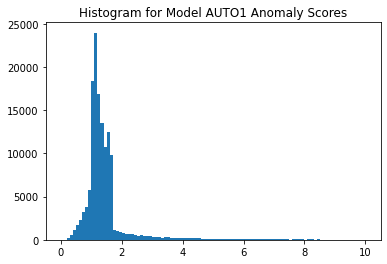

In [ ]:
plt.hist(y_test_scores_auto1, bins = 100, range=(0,10))  # arguments are passed to np.histogram
plt.title("Histogram for Model AUTO1 Anomaly Scores")
plt.show()

In [ ]:
df_test_auto1 = X_test1.copy()
df_test_auto1['score'] = y_test_scores_auto1

In [ ]:
df_test_auto1['cluster'] = np.where(df_test_auto1['score']<1.9, 0, 1)
df_test_auto1['cluster'].value_counts()

0    126654
1     14562
Name: cluster, dtype: int64

In [ ]:
# describe outliers
df_test_auto1.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,score
cluster,,,,,,,,,,
0,-0.046241,-0.096950,-0.177105,-0.19046,-0.078523,-0.053362,-0.168350,-0.030370,-0.209664,1.227581
1,0.425858,0.837513,1.550403,1.64892,0.660723,0.477163,1.443747,0.276295,1.821325,4.782680


Out of 141216 test data, 14562 transactional data are labeled to be outliers (10.31%)

### Auto-encoder Model2

In [ ]:
auto2 = AutoEncoder(hidden_neurons =[9, 4, 2, 4, 9])
auto2.fit(X_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 9)                 90        
_________________________________________________________________
dropout_6 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 90        
_________________________________________________________________
dropout_7 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 90        
_________________________________________________________________
dropout_8 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[9, 4, 2, 4, 9],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f21d8d7f510>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [ ]:
y_train_scores_auto2 = auto2.decision_scores_  # raw outlier scores
y_train_scores_auto2

array([0.82092259, 1.09660938, 3.18918015, ..., 1.40207489, 0.7174322 ,
       1.04036807])

In [ ]:
# get the prediction on the test data
y_test_pred_auto2 = auto2.predict(X_test)  # outlier labels (0 or 1)
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores_auto2 = auto2.decision_function(X_test)  # outlier scores

array([0.78819569, 1.0883416 , 1.16594188, ..., 1.48165415, 1.27062732,
       1.12045148])

In [ ]:
y_test_pred_auto2 = pd.Series(y_test_pred_auto2)
y_test_scores_auto2 = pd.Series(y_test_scores_auto2)

In [ ]:
y_test_pred_auto2.value_counts()

0    127059
1     14157
dtype: int64

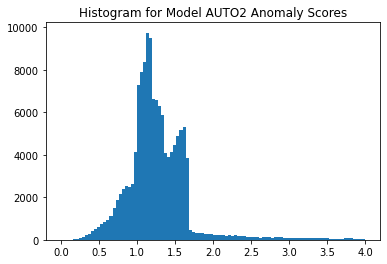

In [ ]:
plt.hist(y_test_scores_auto2, bins = 100, range=(0,4))  # arguments are passed to np.histogram
plt.title("Histogram for Model AUTO2 Anomaly Scores")
plt.show()

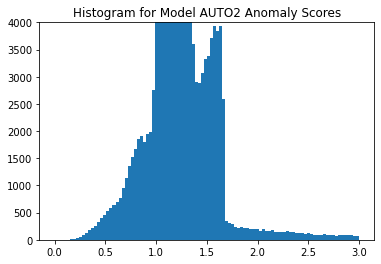

In [ ]:
# zoom in
plt.hist(y_test_scores_auto2, bins = 100, range=(0,3))  # arguments are passed to np.histogram
plt.title("Histogram for Model AUTO2 Anomaly Scores")
axes = plt.gca()
axes.set_ylim([0,4000])
plt.show()

In [ ]:
df_test_auto2 = X_test1.copy()
df_test_auto2['score'] = y_test_scores_auto2

In [ ]:
df_test_auto2['cluster'] = np.where(df_test_auto2['score']<1.7, 0, 1)
df_test_auto2['cluster'].value_counts()

0    129836
1     11380
Name: cluster, dtype: int64

In [ ]:
# describe outliers
df_test_auto2.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,score
cluster,,,,,,,,,,
0,-0.041593,-0.087840,-0.152406,-0.161298,-0.053165,-0.046350,-0.150551,-0.026387,-0.175420,1.193271
1,0.504830,0.994861,1.751650,1.830523,0.578112,0.545504,1.691434,0.316606,1.998518,4.413837


Out of 141216 test data, 11380 transactional data are labeled to be outliers (8.06%)

### AutoEncoder Model 3

In [ ]:
auto3 = AutoEncoder(hidden_neurons =[9, 6, 4, 2, 4, 6, 9])
auto3.fit(X_train)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 9)                 90        
_________________________________________________________________
dropout_13 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 9)                 90        
_________________________________________________________________
dropout_14 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 9)                 90        
_________________________________________________________________
dropout_15 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 6)                

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[9, 6, 4, 2, 4, 6, 9],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f21d8d7f510>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [ ]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores_auto3 = auto3.decision_function(X_test)  # outlier scores
y_test_scores_auto3 = pd.Series(y_test_scores_auto3)

In [ ]:
y_test_pred_auto3

0         0
1         0
2         0
3         0
4         1
         ..
141211    0
141212    0
141213    0
141214    0
141215    0
Length: 141216, dtype: int64

In [ ]:
# get the prediction on the test data
y_test_pred_auto3 = auto3.predict(X_test)
y_test_pred_auto3 = pd.Series(y_test_pred_auto3)
y_test_pred_auto3.value_counts()

0    127167
1     14049
dtype: int64

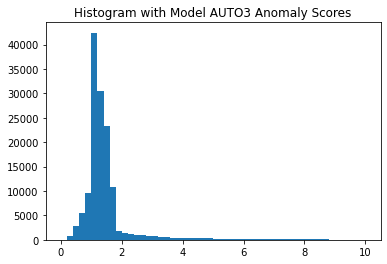

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores_auto3, bins = 50, range=(0,10))  
plt.title("Histogram with Model AUTO3 Anomaly Scores")
plt.show()

In [ ]:
df_test_auto3 = X_test1.copy()
df_test_auto3['score'] = y_test_scores_auto3

In [ ]:
df_test_auto3['cluster'] = np.where(df_test_auto3['score']<1.9, 0, 1)
df_test_auto3['cluster'].value_counts()

0    126646
1     14570
Name: cluster, dtype: int64

In [ ]:
# describe outliers
df_test_auto3.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,score
cluster,,,,,,,,,,
0,-0.046251,-0.096972,-0.177154,-0.190526,-0.078568,-0.053374,-0.168385,-0.030378,-0.209719,1.227181
1,0.425686,0.837189,1.549882,1.648485,0.660709,0.476973,1.443166,0.276197,1.820688,4.782017


Out of 141216 test data, 14570 transactional data are labeled to be outliers (10.32%)

### Achieve Model Stability 
by Aggregating Multiple Models
Unsupervised techniques can detect many outliers. But due to its unspervised nature it is not stable, meaning overfitting to a specific dataset.
The solution is to train multiple models then aggregate the scores.

There are four methods to aggregate the outcome:

(1) Average: average scores of all detectors

(2) Maximum of Maximum (MOM)

(3) Average of Maximum (AOM)

(4) Maximum of Average (MOA)

In [ ]:
from pyod.models.combination import aom, moa, average, maximization

# Put all the predictions in a data frame
train_scores_auto = pd.DataFrame({'auto1': auto1.decision_scores_,
                             'auto2': auto2.decision_scores_,
                             'auto3': auto3.decision_scores_
                            })

test_scores_auto  = pd.DataFrame({'auto1': auto1.decision_function(X_test),
                             'auto2': auto2.decision_function(X_test),
                             'auto3': auto3.decision_function(X_test) 
                            })

In [ ]:
train_scores_auto.head()

In [ ]:
test_scores_auto.head()

In [ ]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
train_scores_norm_auto, test_scores_norm_auto = standardizer(train_scores_auto,test_scores_auto)

In [ ]:
train_scores_norm_auto.shape

Average

The "average" function in PyOD averages the outlier scores from multiple estimators.

In [ ]:
# Combination by average
y_by_average_auto = average(test_scores_norm_auto)
y_by_average_auto[1:10]

In [ ]:
# Combination by average
y_by_average_auto = average(test_scores_norm_auto)
             
import matplotlib.pyplot as plt
plt.hist(y_by_average_auto, bins = 50, range=(0,10))  # arguments are passed to np.histogram
plt.title("Combination by average - AutoEncoder")
plt.show()

In [ ]:
#zoom in
plt.hist(y_by_average_auto, bins = 50, range=(0,2))  # arguments are passed to np.histogram
plt.title("Combination by average - AutoEncoder")
axes = plt.gca()
axes.set_ylim([0,4000])
plt.show()

In [ ]:
df_test_autoavg = X_test1.copy()
df_test_autoavg['score'] = y_by_average_auto

In [ ]:
df_test_autoavg['cluster'] = np.where(df_test_autoavg['score']<0.2, 0, 1)
df_test_autoavg['cluster'].value_counts()

In [ ]:
df_test_autoavg.groupby('cluster').mean()

Out of 141216 test data, 11826 transactional data are labeled to be outliers (8.37%). 

Maximum of maximum

Merge the outlier scores from multiple estimators by taking the maximum.

In [ ]:
# Combination by max
y_by_maximization_auto = maximization(test_scores_norm_auto)

import matplotlib.pyplot as plt
plt.hist(y_by_maximization_auto, bins = 50, range=(0,2))  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [ ]:
df_test_automax = X_test1.copy()
df_test_automax['score'] = y_by_maximization_auto

In [ ]:
df_test_automax['y_by_maximization_cluster'] = np.where(df_test_automax['score']<0.2, 0, 1)
df_test_automax['y_by_maximization_cluster'].value_counts()

In [ ]:
df_test_automax.groupby('y_by_maximization_cluster').mean()

Out of 141216 test data,13031 are labeled to be anomalies (9.22%)

### AutoEncoder Conclusion

The general statistis of the IForest result is:

*   Outlier group contains around than 10% of overall test transaction data
*   For all these models, the summary statistics show that cluster 1 (outlier group) has all positive values for these standardized values.
*   For the outlier cluster, the largest average value is column 8, which is the ratio of each transaction comparing to the cardholder historical average spending. This means that anomalous transactions tend to have a large number for this ratio. 
*   For the outlier cluster, the small average value is column 7, which is the percentage of each transaction exceed the minimum amount for each agent. This indicates that this feature may not be a strong indicator of anomalies.


## KNN


### KNN Model 1: Default

In [ ]:
# train kNN detector
from pyod.models.knn import KNN
clf_name = 'KNN'
knn = KNN()
knn.fit(X_train)
# If you want to see the predictions of the training data, you can use this way:
y_train_scores_knn = knn.decision_scores_

In [ ]:
# get the prediction labels and outlier scores of the training data
y_train_pred = knn.labels_  # binary labels (0: inliers, 1: outliers)

In [ ]:
# Now we have the trained K-NN model, let's apply to the test data to get the predictions
y_test_pred_knn = knn.predict(X_test) # outlier labels (0 or 1)
unique, counts = np.unique(y_test_pred_knn, return_counts=True)
dict(zip(unique, counts))

{0: 127155, 1: 14061}

In [ ]:
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

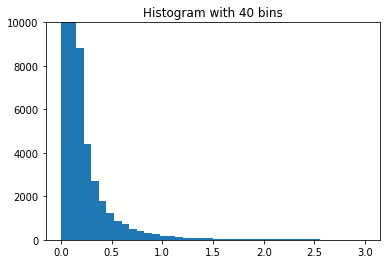

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores_knn, bins=40, range = (0,3))  # arguments are passed to np.histogram
plt.title("Histogram with 40 bins")
axes = plt.gca()
axes.set_ylim([0,10000])
plt.show()

1 is the cutting point

In [ ]:
df_test_knn1 = X_test1.copy()
df_test_knn1['score'] = y_test_scores_knn

In [ ]:
df_test_knn1['cluster'] = np.where(df_test_knn1['score']<1, 0, 1)
df_test_knn1['cluster'].value_counts()

0    139778
1      1438
Name: cluster, dtype: int64

In [ ]:
# Now let's show the summary statistics:
df_test_knn1.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,score
cluster,,,,,,,,,
0,-0.022198,-0.054724,-0.050588,-0.010272,-0.046414,-0.020208,-0.040081,-0.012594,0.08704
1,2.397406,5.420862,4.840157,0.773320,4.488896,2.096372,3.688457,1.347186,3.12318


By selecting 1 as the cut off point, out of 141216 creditcard transaction data, 1438 (1.02%) of the data is labeled to be outliers. 

In [97]:
ccard3.columns

Index(['Amount', 'Agency_Merchant_AvgSpending_Ratio',
       'Agency_Merchant_Monthly_AvgSpending_Ratio',
       'Monthly_Max_VendorSpending_Ratio', 'cardholer_AvgSpending_Ratio',
       'Agency_AvgSpending_Ratio', 'Agency_MaxSpending_Ratio',
       'Agency_Exceed_MinSpending_Percentage'],
      dtype='object')

### KNN Model 2-5 Achieve Model Stability by Aggregating Multiple Models
*   Average
*   Maximum of Maximum (MOM)
*   Average of Maximum (AOM)
*   Maximum of Average (MOA)

In [ ]:
X_train_norm, X_test_norm = standardizer(X_train, X_test)

In [ ]:
# Test a range of k-neighbors from 10 to 190, with a 20 gap. There will be 10 k-NN models.
n_clf = 10
k_list = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190]

In [ ]:
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape

(286711, 10)

In [ ]:
# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train)

    # Store the results in each column:
    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test) 

In [ ]:
from pyod.utils.utility import standardizer
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

In [ ]:
from pyod.models.combination import aom, moa, average, maximization

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Combination by average
# The test_scores_norm is 500 x 20. The "average" function will take the average of the 20 columns. The result "y_by_average" is a single column: 
y_by_average = average(test_scores_norm)

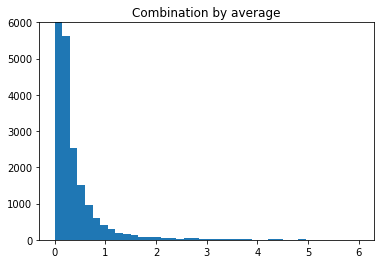

In [ ]:
plt.hist(y_by_average, bins=40, range=(0,6)) # arguments are passed to np.histogram
plt.title("Combination by average")
axes = plt.gca()
axes.set_ylim([0,6000])
plt.show()

Cutting point is set to be 2

In [ ]:
df_test_avg = pd.DataFrame(X_test)
df_test_avg['score'] = y_by_average

In [ ]:
df_test_avg['cluster'] = np.where(df_test_avg['score']<2, 0, 1)
df_test_avg['cluster'].value_counts()

0    140597
1       619
Name: cluster, dtype: int64

In [ ]:
df_test_avg.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,score
cluster,,,,,,,,,
0,-0.017347,-0.034699,-0.03109,-0.006164,-0.026001,-0.014615,-0.028805,-0.009562,-0.024268
1,4.496958,8.117028,6.88241,0.877108,5.853094,3.626448,6.060457,2.457625,6.161408


By selecting 2 as the cut off point, out of 141216 creditcard transaction data, 619 (0.44%) of the data is labeled to be outliers. 

Method 2: The Maximum of Maximum (MOM)

In [ ]:
# Combination by mom
y_by_maximization = maximization(test_scores_norm)

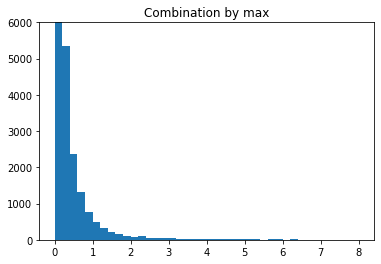

In [ ]:
plt.hist(y_by_maximization, bins=40,range=(0,8))  # arguments are passed to np.histogram
plt.title("Combination by max")
axes = plt.gca()
axes.set_ylim([0,6000])
plt.show()

2 is the cutting point

In [ ]:
df_test_max = pd.DataFrame(X_test)
df_test_max['score'] = y_by_maximization

In [ ]:
df_test_max['cluster'] = np.where(df_test_max['score']<2, 0, 1)
df_test_max['cluster'].value_counts()

0    140451
1       765
Name: cluster, dtype: int64

In [ ]:
df_test_max.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,score
cluster,,,,,,,,,
0,-0.018225,-0.038645,-0.035048,-0.007054,-0.030745,-0.015612,-0.034048,-0.010058,0.000756
1,3.796680,7.285841,6.289672,0.871857,5.602010,3.114550,5.861014,2.077943,6.045548


By selecting 2 as the cut off point, out of 141216 creditcard transaction data, 765 (0.54%) of the data is labeled to be outliers. 

Method 3: The Average of Maximum (AOM)

In [ ]:
# Combination by aom
y_by_aom = aom(test_scores_norm, n_buckets=5)

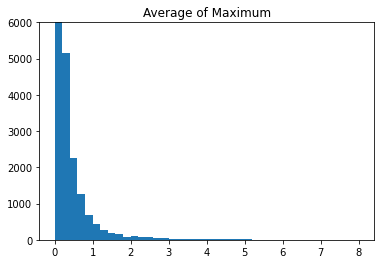

In [ ]:
plt.hist(y_by_aom, bins=40,range=(0,8))  # arguments are passed to np.histogram
plt.title("Average of Maximum")
axes = plt.gca()
axes.set_ylim([0,6000])
plt.show()

2 is the cutting point

In [ ]:
df_test_aom = pd.DataFrame(X_test)
df_test_aom['score'] = y_by_aom

In [ ]:
df_test_aom['cluster'] = np.where(df_test_aom['score']<2, 0, 1)
df_test_aom['cluster'].value_counts()

0    140530
1       686
Name: cluster, dtype: int64

In [ ]:
df_test_aom.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,score
cluster,,,,,,,,,
0,-0.017737,-0.036543,-0.033038,-0.006539,-0.028223,-0.015082,-0.031055,-0.009800,-0.018113
1,4.136004,7.698614,6.606273,0.867536,5.733954,3.366554,5.926822,2.265557,6.053452


By selecting 2 as the cut off point, out of 141216 creditcard transaction data, 686 (0.49%) of the data is labeled to be outliers.

Method 4: The maximum of average (MOA)

In [ ]:
# Combination by moa
y_by_moa = moa(test_scores_norm, n_buckets=5)

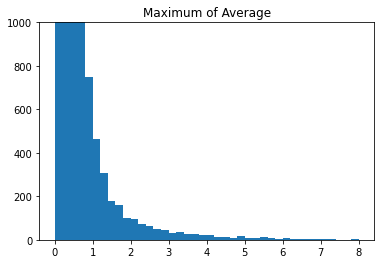

In [ ]:
plt.hist(y_by_moa, bins=40,range=(0,8))  # arguments are passed to np.histogram
plt.title("Maximum of Average")
axes = plt.gca()
axes.set_ylim([0,1000])
plt.show()

In [ ]:
df_test_moa = pd.DataFrame(X_test)
df_test_moa['score'] = y_by_moa

In [ ]:
df_test_moa['cluster'] = np.where(df_test_moa['score']<3, 0, 1)
df_test_moa['cluster'].value_counts()

0    140818
1       398
Name: cluster, dtype: int64

In [ ]:
df_test_moa.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,score
cluster,,,,,,,,,
0,-0.015203,-0.027701,-0.024416,-0.004825,-0.019518,-0.012286,-0.020099,-0.008352,-0.008835
1,6.245086,10.167806,8.360121,0.893870,6.823794,4.824038,6.361606,3.399749,8.972887


By selecting 3 as the cut off point, out of 141216 creditcard transaction data, 398 (0.28%) of the data is labeled to be outliers. 

### KNN Conclusion

The general statistis of knn result is:

*   Outlier group contains less than 1% of overall test transaction data
*   For all these models, the summary statistics show that cluster 1 (outlier group) has all positive values for these standardized values.
*   All methods have a similar anomaly score cutting point (either 1, 2, or 3), and the anomaly percentage is roughly the same as well.
*   For all methods, in the outlier cluster, the largest mean value is column index 1, which is the ratio of each transaction comparing to the average spending on each merchant for each agent. This means that anomalous transactions tend to have a large number for this ratio.
*   For all methods, in the outlier cluster, the smallest mean value is column index 3, which is the ratio of each transaction comparing to the monthly maximum spending at each vendor for each agent. This indicates that this feature may not be a strong indicator of anomalies.

## PCA

In [22]:
# PyOD
from pyod.utils.data import generate_data, get_outliers_inliers
from pyod.models.pca import PCA
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

### PCA model 1: Keep all PCs

In [32]:
pca = PCA()
pca.fit(X_train)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [33]:
df_train = pd.DataFrame(X_train)

In [35]:
y_train_pred_pca = pca.labels_
y_train_scores_pca = pca.decision_scores_

In [62]:
y_test_pred_pca = pca.predict(X_test1)

In [63]:
y_test_scores_pca = pca.decision_function(X_test1)

In [64]:
y_test_scores_pca = pd.Series(y_test_scores_pca)
y_test_pred_pca = pd.Series(y_test_pred_pca)

In [65]:
y_test_scores_pca

0         1303.577935
1         1501.458927
2         1560.913058
3         1378.223892
4         4696.697677
             ...     
141211    1540.705200
141212    1447.958336
141213    1824.176967
141214    1639.332240
141215    1535.986702
Length: 141216, dtype: float64

In [66]:
unique,counts = np.unique(y_test_pred_pca,return_counts=True)
dict(zip(unique,counts))

{0: 127131, 1: 14085}

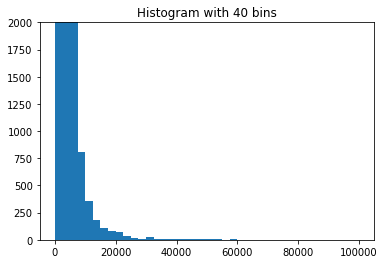

In [67]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores_pca, bins=40,range=(0,100000))  # arguments are passed to np.histogram
plt.title("Histogram with 40 bins")
axes = plt.gca()
axes.set_ylim([0,2000])
plt.show()

In [54]:
df_test_pca_all = X_test1.copy()
df_test_pca_all['score'] = y_test_scores_pca

In [56]:
df_test_pca_all['cluster'] = np.where(df_test_pca_all['score']<20000, 0, 1)
df_test_pca_all['cluster'].value_counts()

0    141003
1       213
Name: cluster, dtype: int64

In [74]:
df_test_pca_all.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,score
cluster,,,,,,,,,
0,-0.011868,-0.018477,-0.016026,-0.003701,-0.012202,-0.009596,-0.016179,-0.006770,1900.386591
1,9.475105,12.916847,10.088152,0.929748,7.924053,7.244051,9.309008,5.312578,36388.097721


By selecting 20000 as the cut off point, out of 141216 creditcard transaction data, 213 (0.15%) of the data is labeled to be outliers.

In [34]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.43945093, 0.2408685 , 0.11505971, 0.10592424, 0.05792456,
       0.02769317, 0.01191797, 0.00116092])

The first four PCs explain more than 90% variance. 
The first five PCs explain more than 95% variance.
The next step is to take a look at these two results

### PCA model 2: Only keep the first four PCs (>90% variance)

In [58]:
pca2 = PCA(n_components=4)
pca2.fit(X_train)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=4,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [59]:
explained_variance2 = pca2.explained_variance_ratio_
explained_variance2

array([0.43945093, 0.2408685 , 0.11505971, 0.10592424])

In [68]:
y_test_scores_pca2 = pca2.decision_function(X_test1)
y_test_scores_pca2 = pd.Series(y_test_scores_pca2)

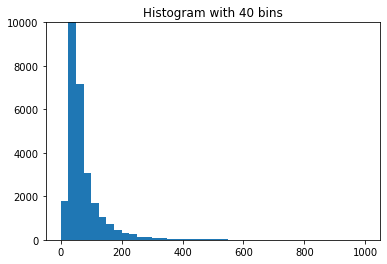

In [71]:
plt.hist(y_test_scores_pca2, bins=40,range=(0,1000))  # arguments are passed to np.histogram
plt.title("Histogram with 40 bins")
axes = plt.gca()
axes.set_ylim([0,10000])
plt.show()

In [72]:
df_test_pca2 = X_test1.copy()
df_test_pca2['score'] = y_test_scores_pca2

In [73]:
df_test_pca2['cluster'] = np.where(df_test_pca2['score']<300, 0, 1)
df_test_pca2['cluster'].value_counts()

0    140618
1       598
Name: cluster, dtype: int64

In [75]:
df_test_pca2.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,score
cluster,,,,,,,,,
0,-0.015322,-0.032840,-0.030078,-0.006146,-0.025696,-0.013422,-0.034456,-0.008532,43.084384
1,4.179275,7.966288,6.887247,0.903942,5.987738,3.473666,7.603173,2.302208,550.600372


By selecting 300 as the cut off point, out of 141216 creditcard transaction data, 598 (0.42%) of the data is labeled to be outliers.

### PCA model 3: Only keep the first five PCs (>95% variance)

In [76]:
pca3 = PCA(n_components=5)
pca3.fit(X_train)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=5,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [77]:
explained_variance3 = pca3.explained_variance_ratio_
explained_variance3

array([0.43945093, 0.2408685 , 0.11505971, 0.10592424, 0.05792456])

In [78]:
y_test_scores_pca3 = pca3.decision_function(X_test1)
y_test_scores_pca3 = pd.Series(y_test_scores_pca3)

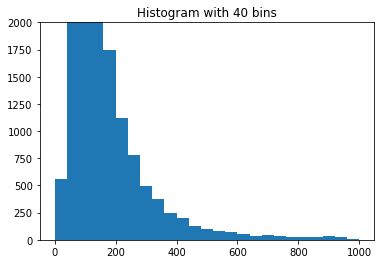

In [88]:
plt.hist(y_test_scores_pca3, bins=25,range=(0,1000))  # arguments are passed to np.histogram
plt.title("Histogram with 40 bins")
axes = plt.gca()
axes.set_ylim([0,2000])
plt.show()

In [89]:
df_test_pca3 = X_test1.copy()
df_test_pca3['score'] = y_test_scores_pca3

In [99]:
df_test_pca3['cluster'] = np.where(df_test_pca3['score']<600, 0, 1)
df_test_pca3['cluster'].value_counts()

0    140794
1       422
Name: cluster, dtype: int64

In [91]:
df_test_pca3.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,score
cluster,,,,,,,,,
0,-0.013805,-0.027517,-0.025079,-0.005043,-0.019376,-0.011847,-0.026951,-0.007831,75.028351
1,5.422556,9.526543,8.104235,0.915218,6.387275,4.402471,8.284546,3.032020,1098.420905


By selecting 600 as the cut off point, out of 141216 creditcard transaction data, 422 (0.3%) of the data is labeled to be outliers.

### PCA Conclusion

The general statistis of knn result is:

*   Outlier group contains less than 0.5% of overall test transaction data
*   In PCA model 1, when not changing the default parameters, the anomaly scores are very high. In model 2 and 3, when selecting the top 4 or 5 PCs, the anomaly score droped. 
*   For all these models, the summary statistics show that cluster 1 (outlier group) has all positive values for these standardized values.
*   For all methods, in the outlier cluster, the largest mean value is column index 1, which is the ratio of each transaction comparing to the average spending on each merchant for each agent. This means that anomalous transactions tend to have a large number for this ratio. 
*   For all methods, in the outlier cluster, the smallest mean value is column index 3, which is the ratio of each transaction comparing to the monthly maximum spending at each vendor for each agent. This indicates that this feature may not be a strong indicator of anomalies.

## KNN & PCA Comparison 
*   The results of KNN and PCA are interesting, as both models indicate that anomaly group's column index 1 (ratio of each transaction comparing to the average spending on each merchant for each agent) has the largest value and column index 3 (the ratio of each transaction comparing to the monthly maximum spending at each vendor for each agent) has the smallest value.
*   If only choose one method of out these two, PCA is preferred because its anomaly score is higher.

